In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy.lib.stride_tricks import as_strided
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from custom_hmm import gmmhmm

In [2]:
fpaths = []
labels = []
for f in os.listdir('Audio'):
    for w in os.listdir('Audio/' + f):
        fpaths.append('Audio/' + f + '/' + w)
        labels.append(f)
        
print('Words spoken:', set(labels))

Words spoken: {'banana', 'apple', 'orange', 'lime', 'pineapple', 'kiwi', 'peach'}


In [3]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
#     print(d.shape)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n

Number of files total: 120


In [4]:

def stft(x, fftsize=64, overlap_pct=.5):   
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

(216, 32)


Text(0.5,1,'PSD of apple example')

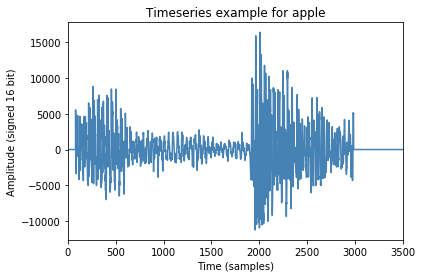

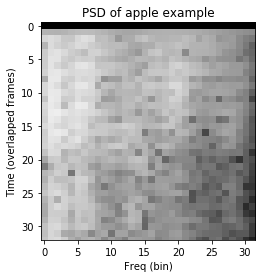

In [5]:

plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

In [6]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_matrix(y_true, y_pred, dictionary):
    array = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(array, index = dictionary,
                      columns = dictionary)
    plt.figure(figsize = (7,5))
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [7]:

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

Text(0,0.5,'Amplitude')

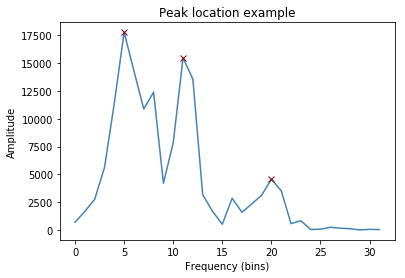

In [8]:
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=8)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

In [9]:
#This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
#MFCC (or deep NN/automatic feature extraction) could be interesting
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100
Processed obs 110


In [10]:
print(all_obs.shape)
print(data.shape)

(120, 6, 216)
(120, 6966)


In [11]:
for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)
    
X_train, X_test, y_train, y_test = train_test_split(all_obs, all_labels, test_size=0.2, random_state=42)

Test accuracy: 62.50 percent


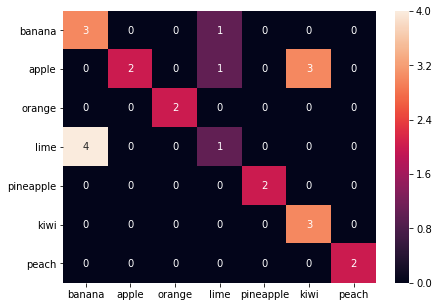

In [12]:
ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
dictionary = list(set(labels))
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))
plot_matrix(y_test, predicted_labels, dictionary)

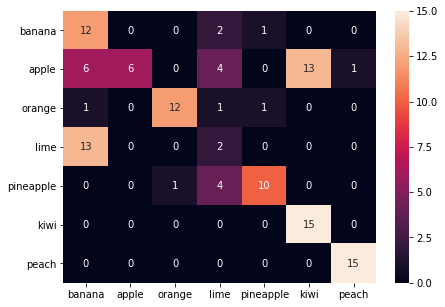

In [13]:
ps = [m.transform(all_obs) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)

plot_matrix(all_labels, predicted_labels, dictionary)